In [1]:
import json
import matplotlib.pyplot as plt
import os
import re

In [2]:
RESULT_PATH = './results/'

## Description
The title of each plot represent:
<ul>
<li> Num_round
<li> Epochs
<li> Number of devices
</ul>

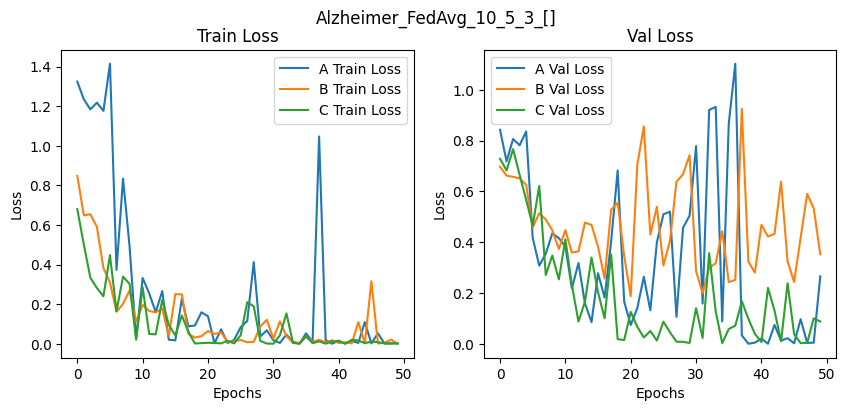

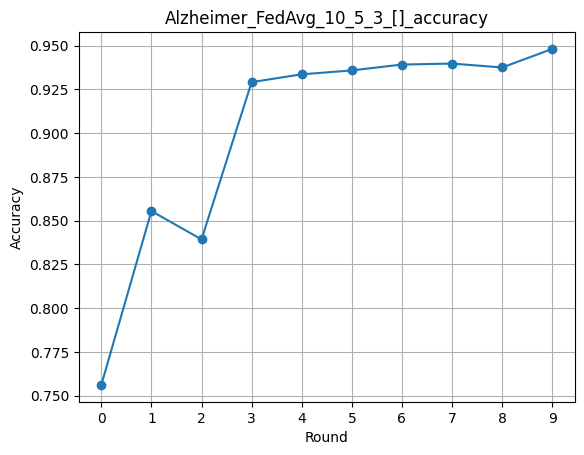

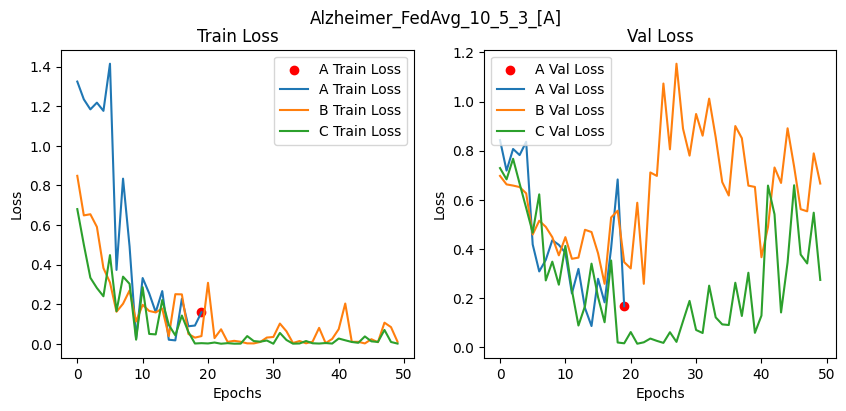

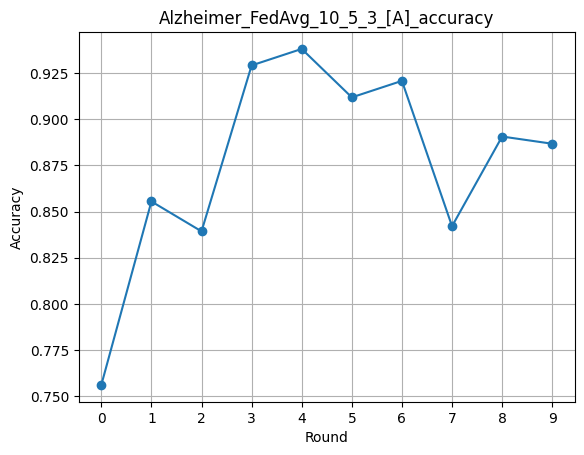

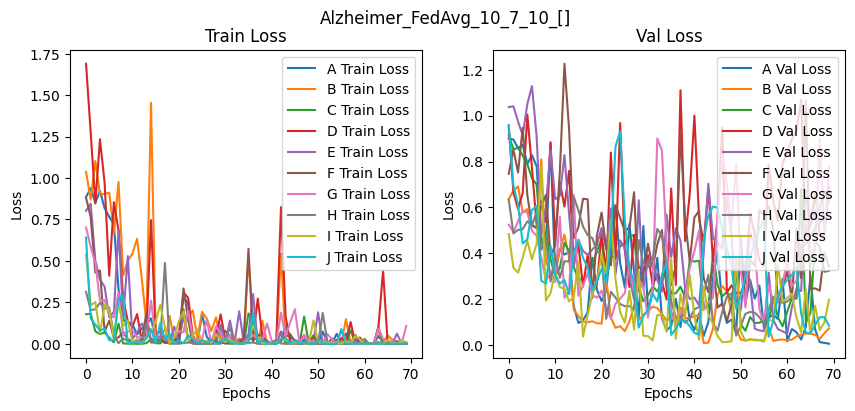

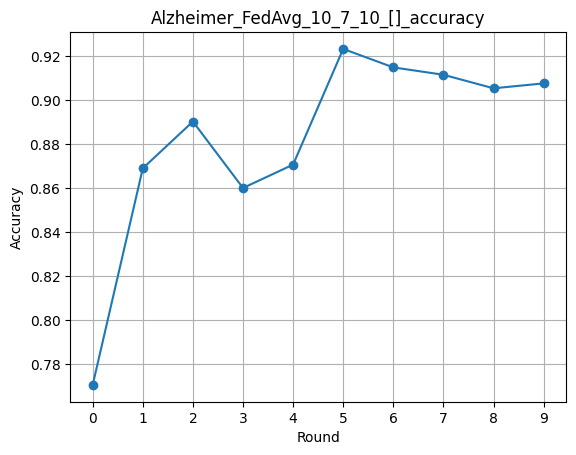

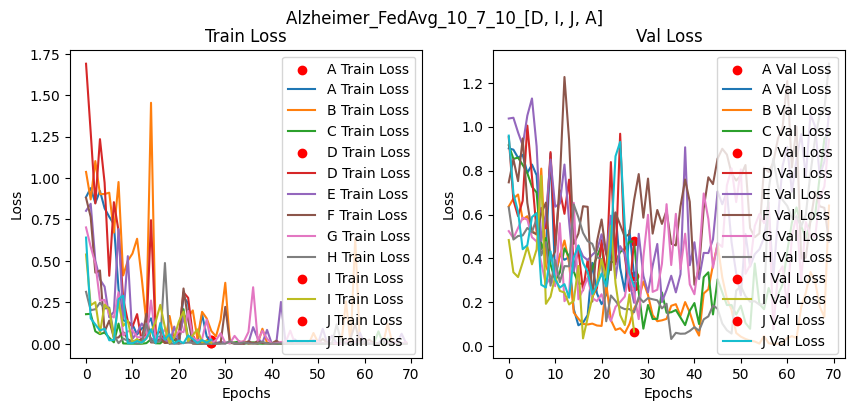

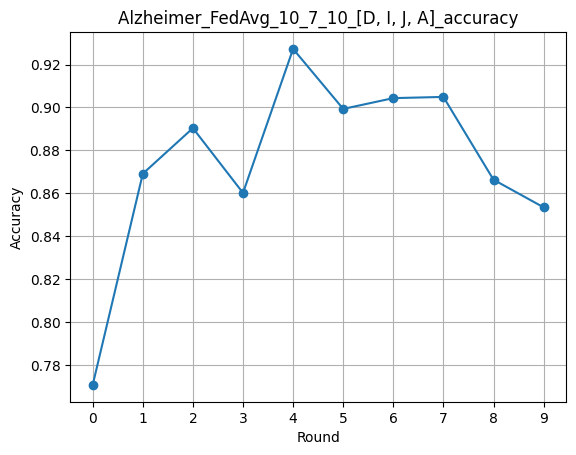

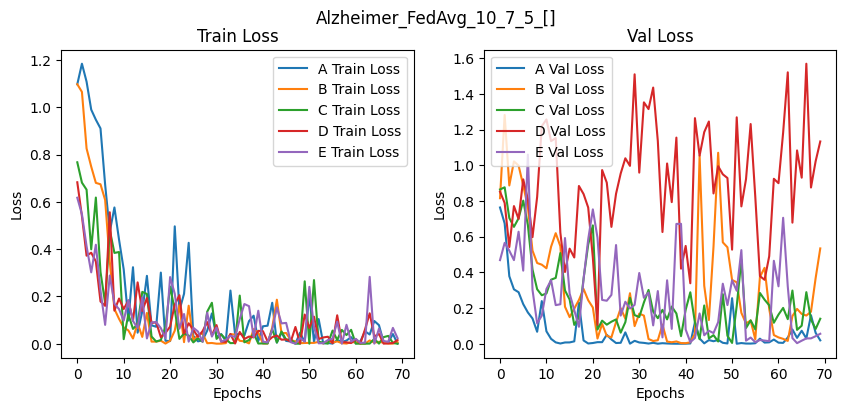

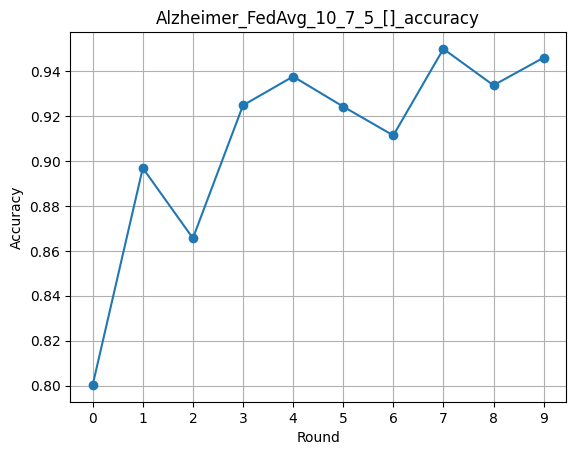

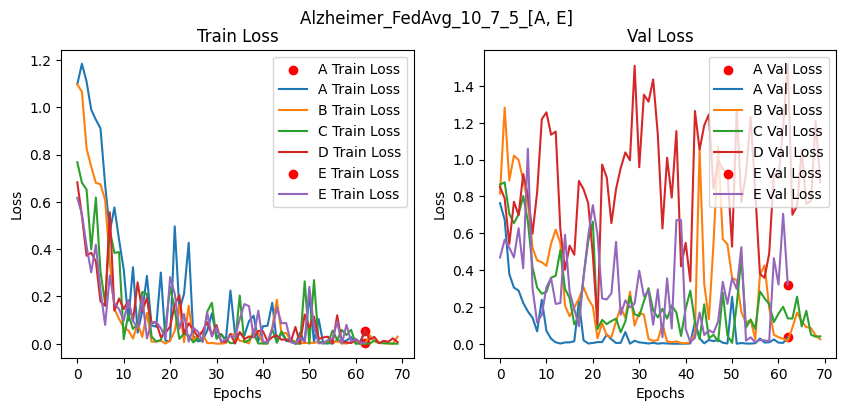

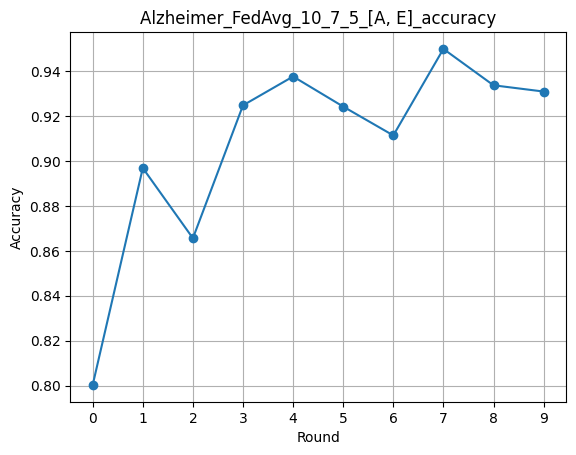

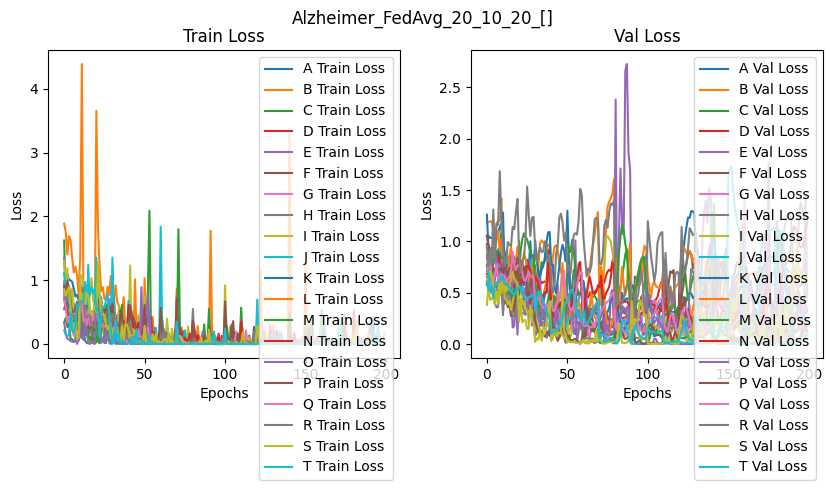

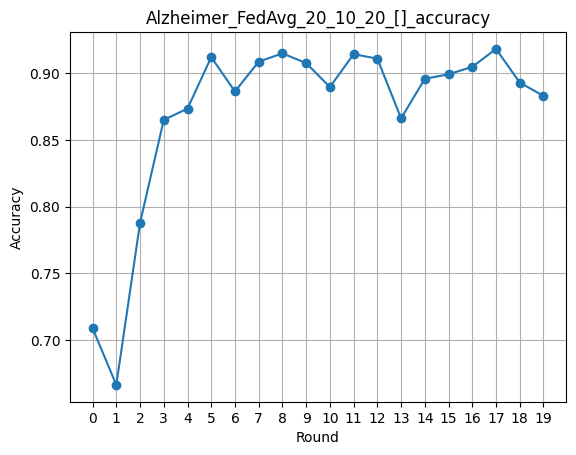

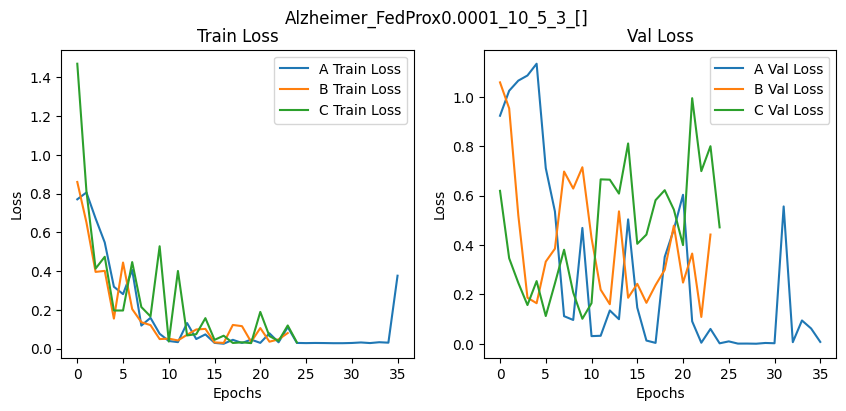

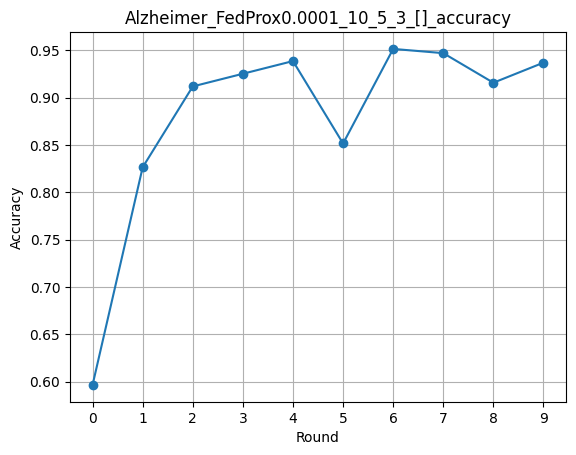

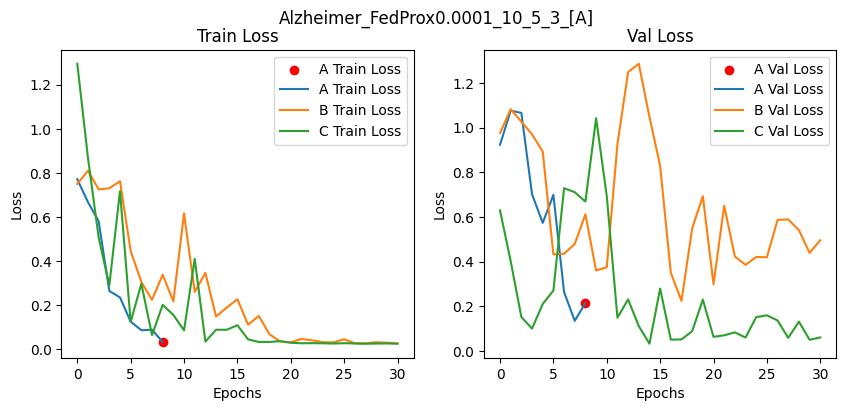

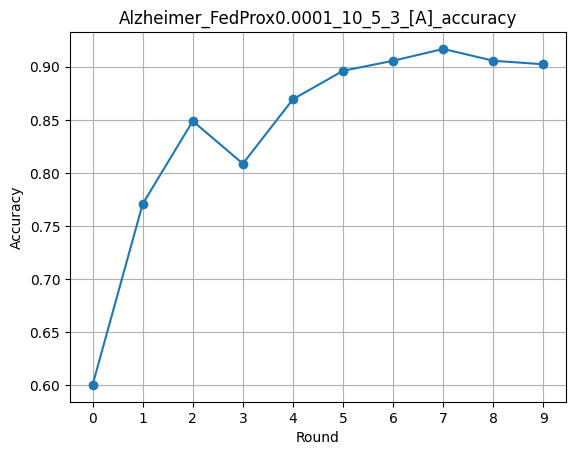

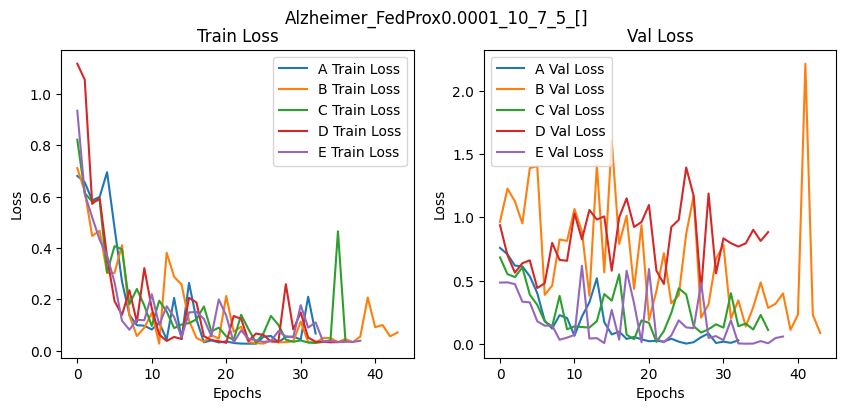

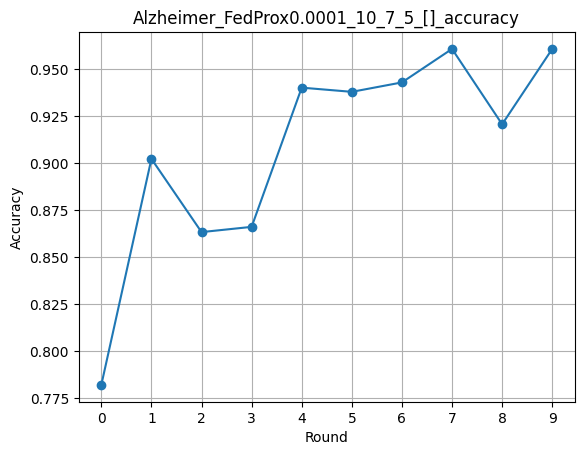

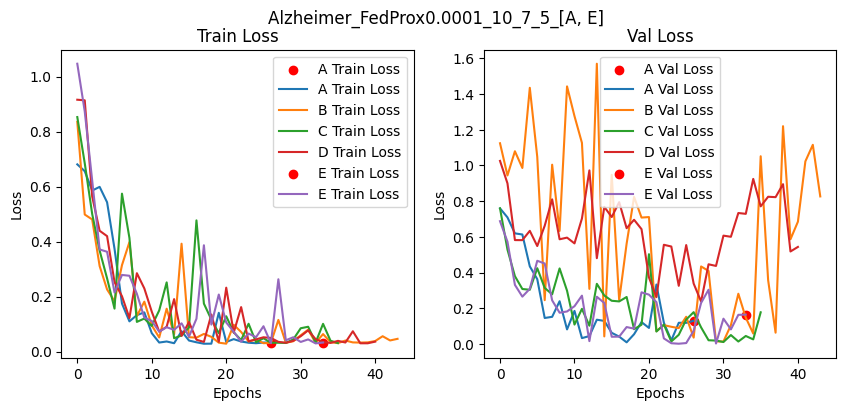

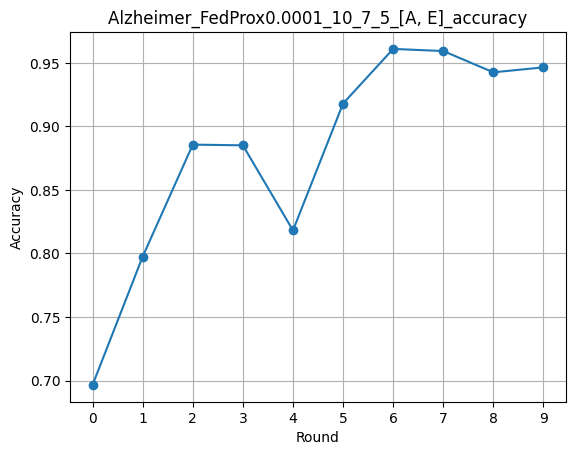

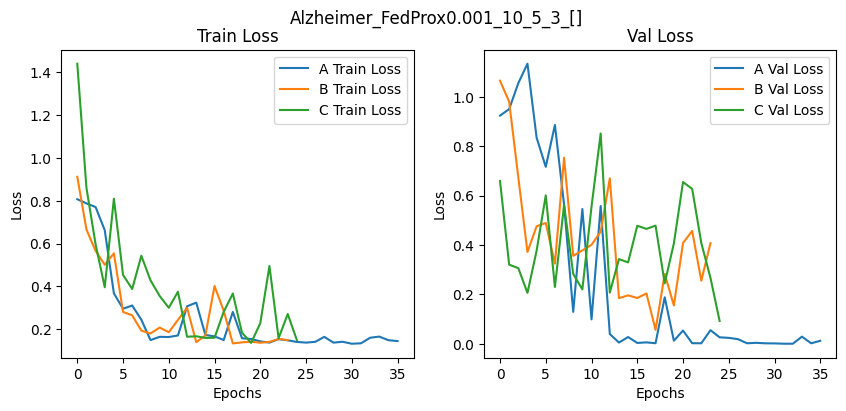

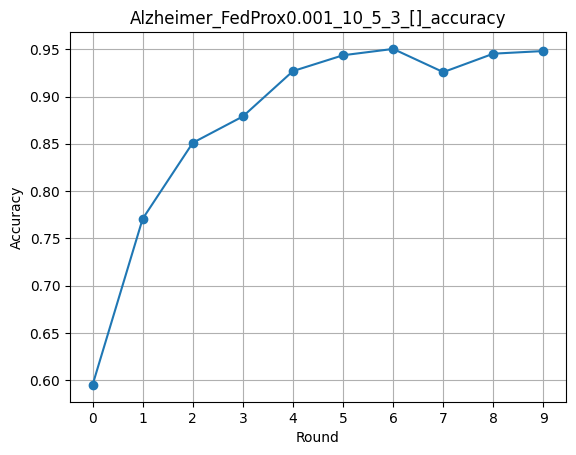

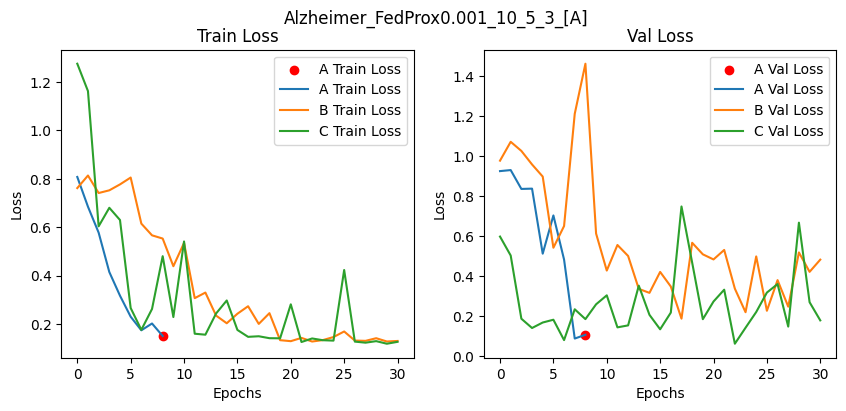

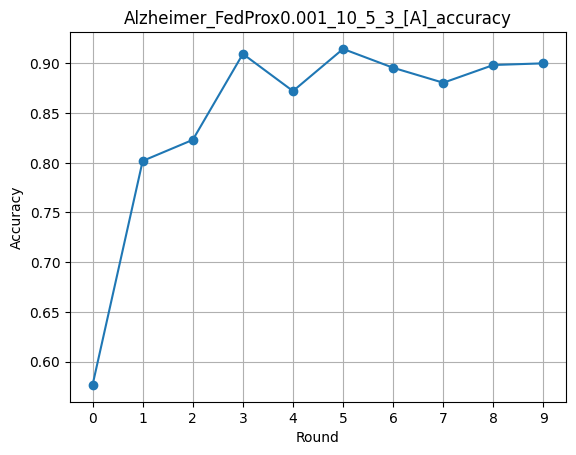

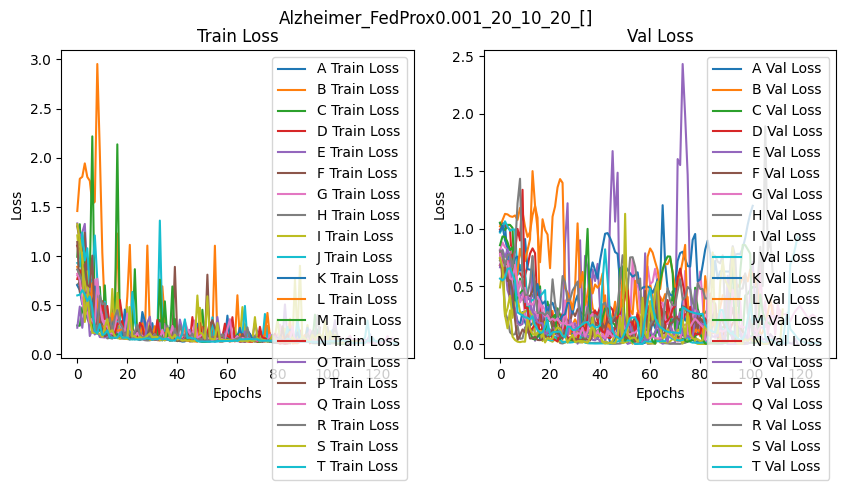

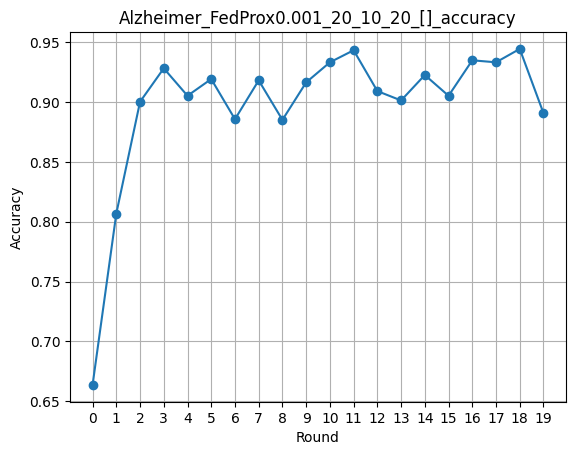

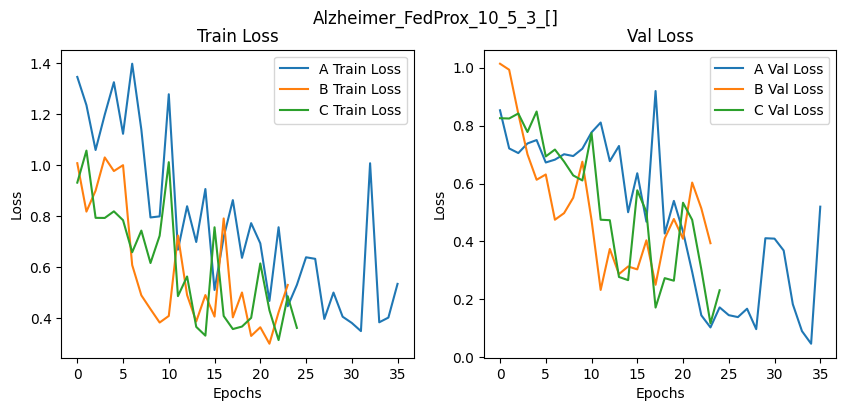

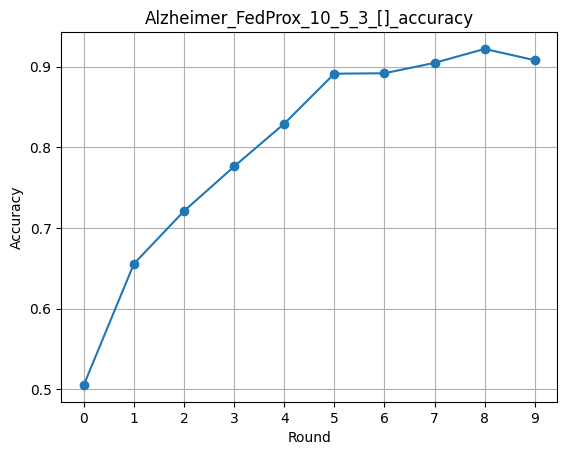

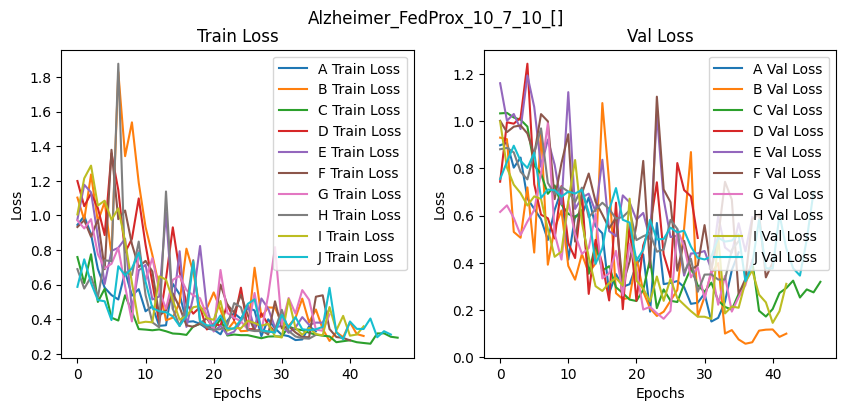

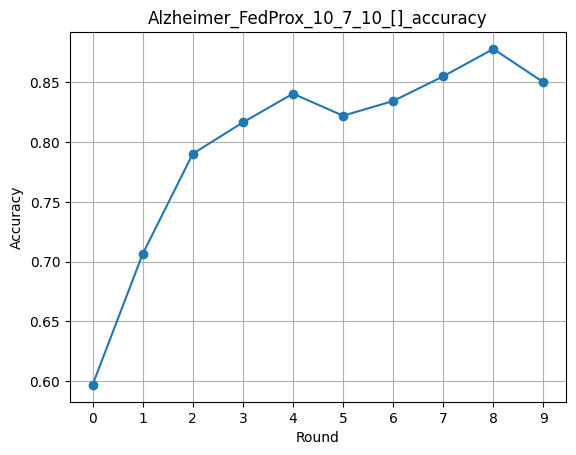

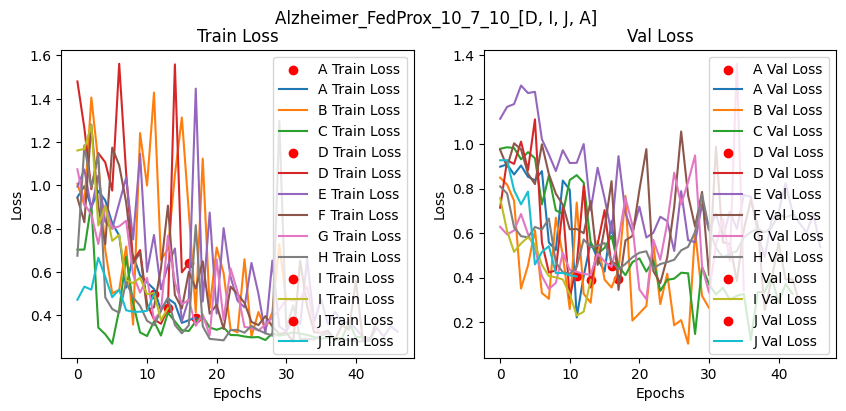

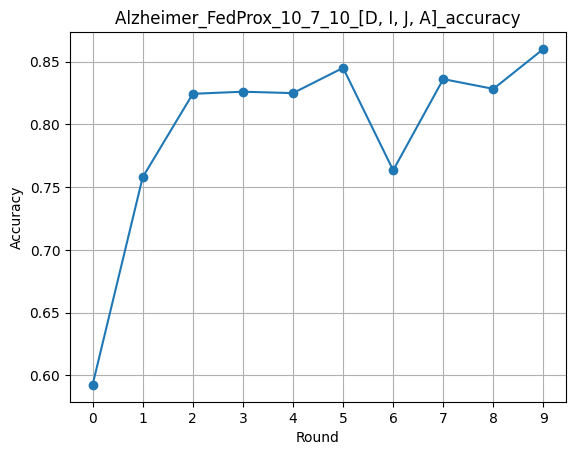

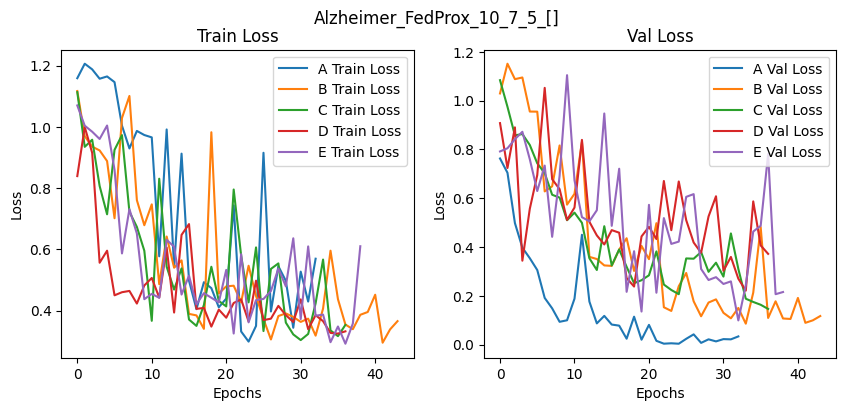

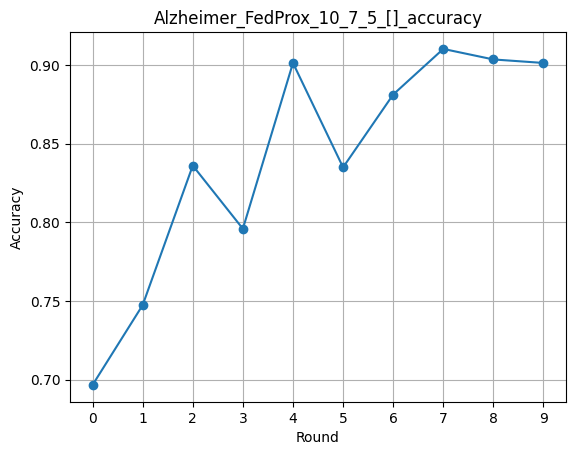

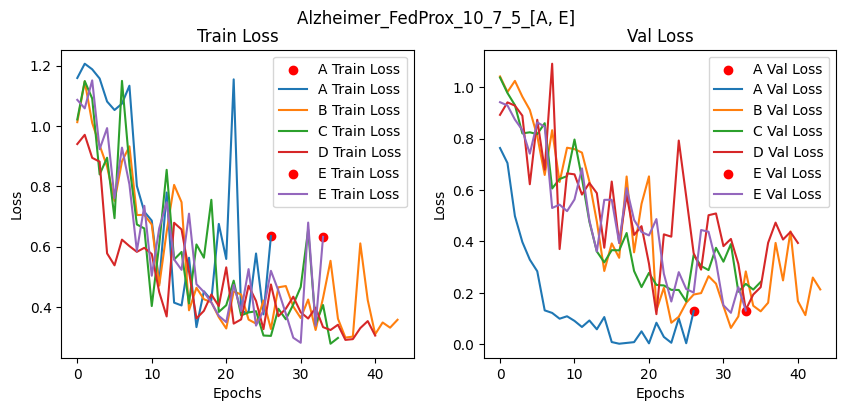

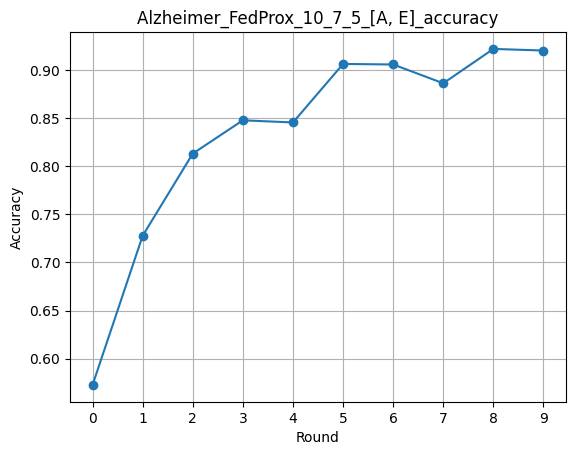

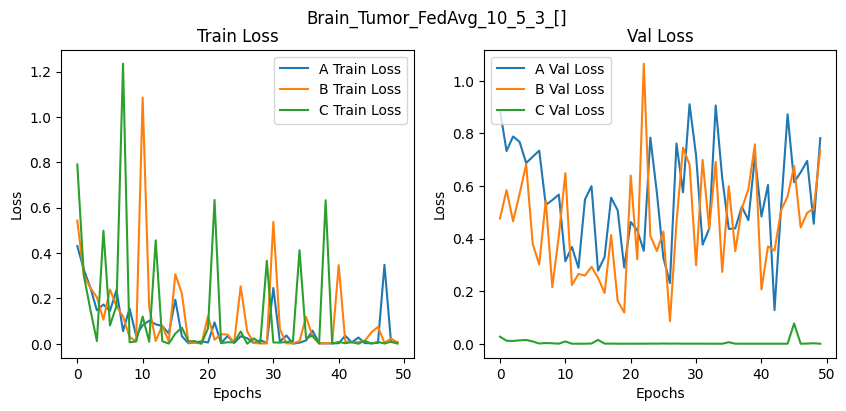

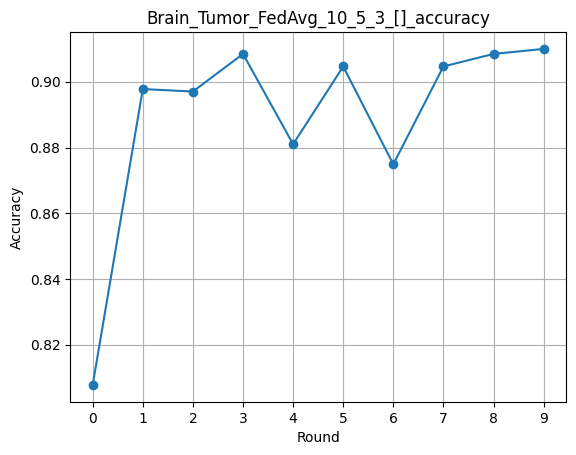

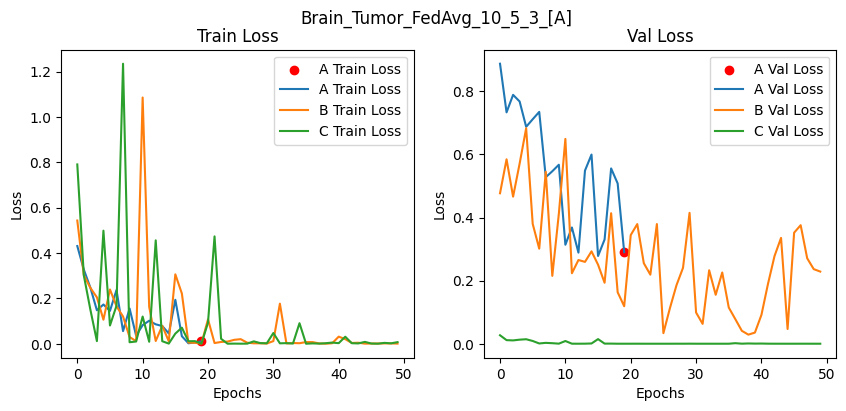

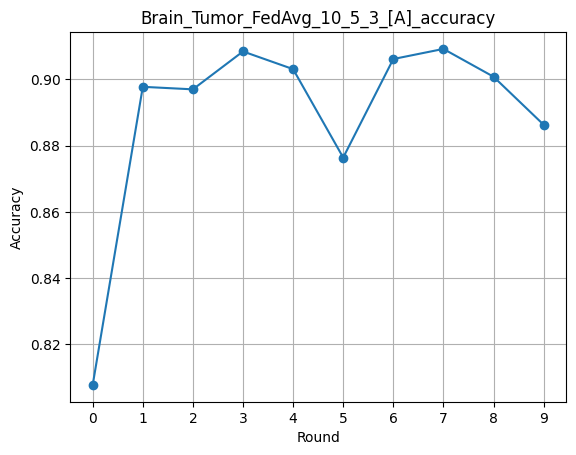

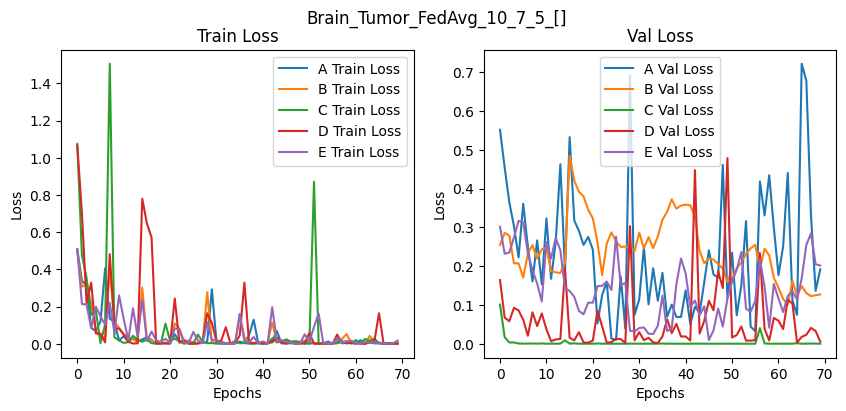

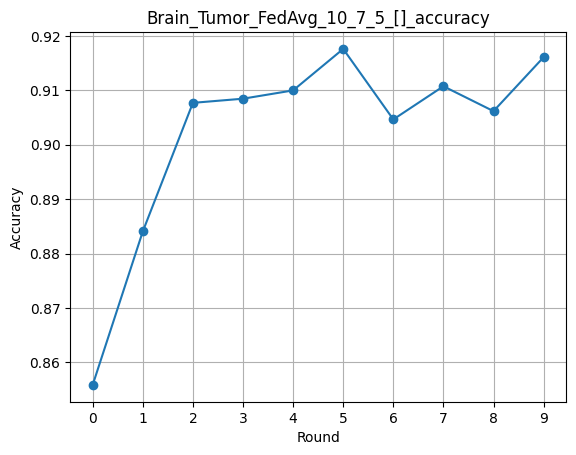

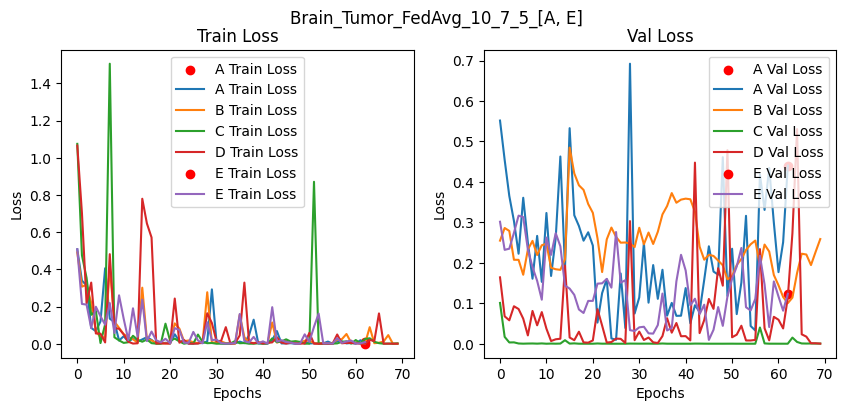

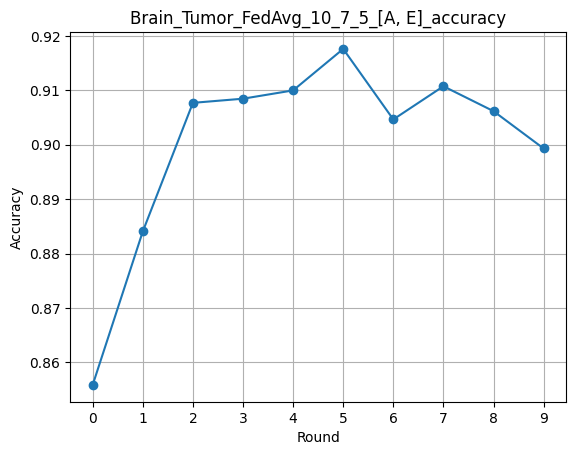

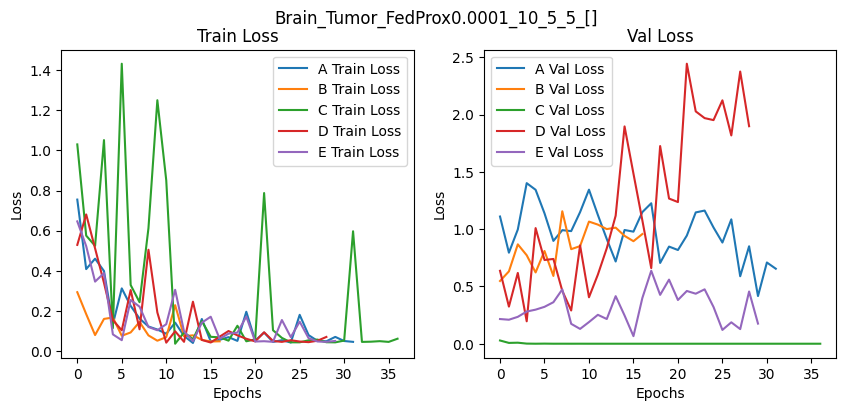

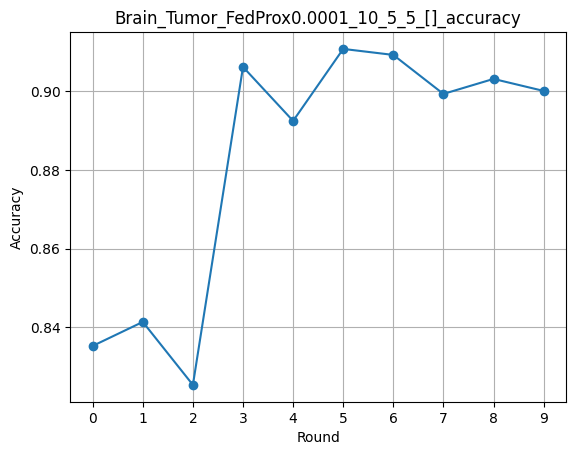

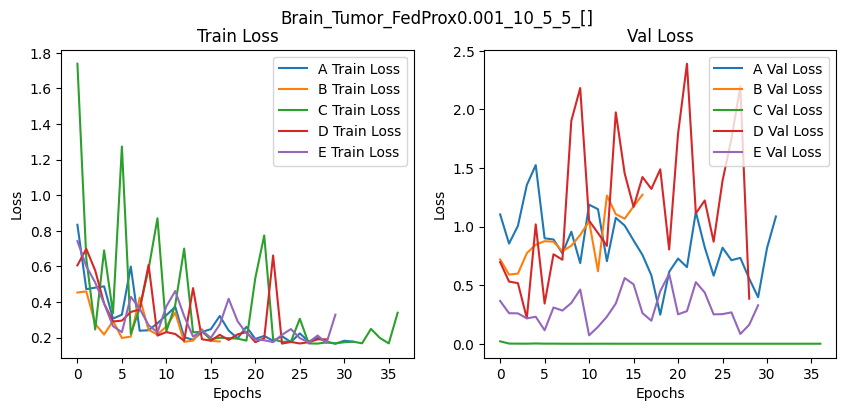

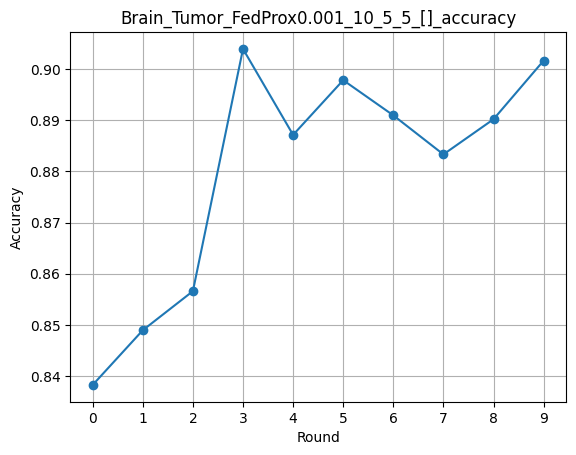

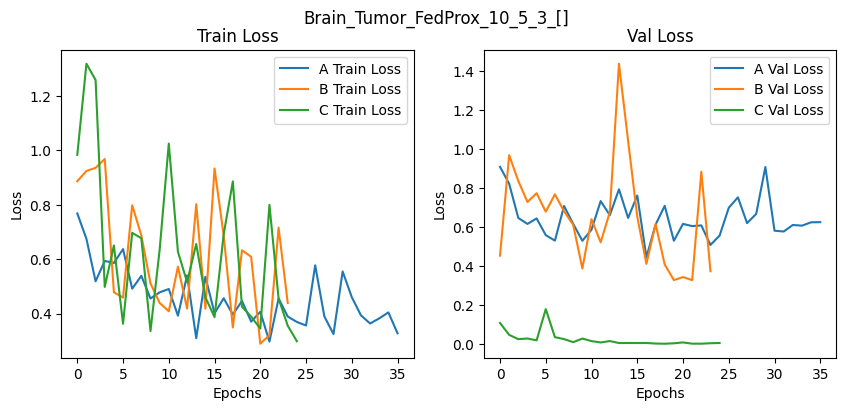

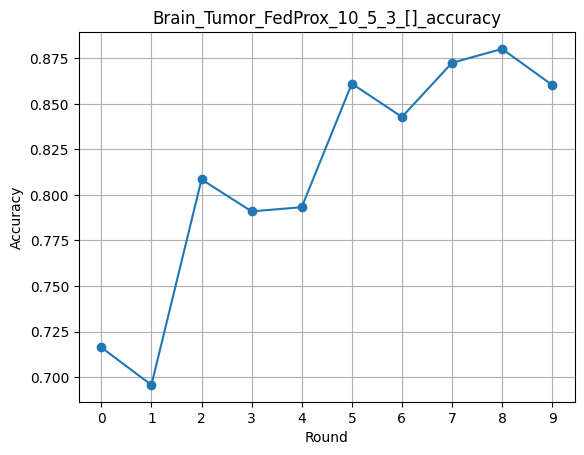

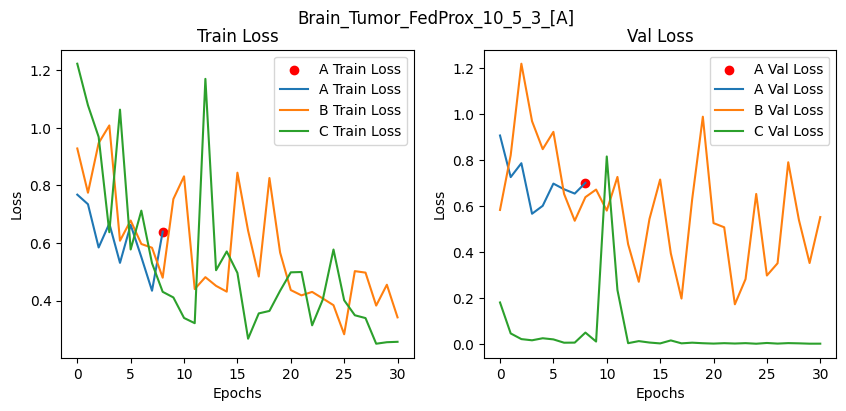

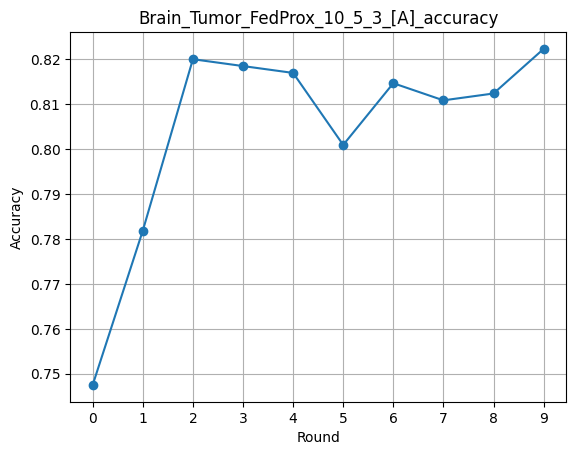

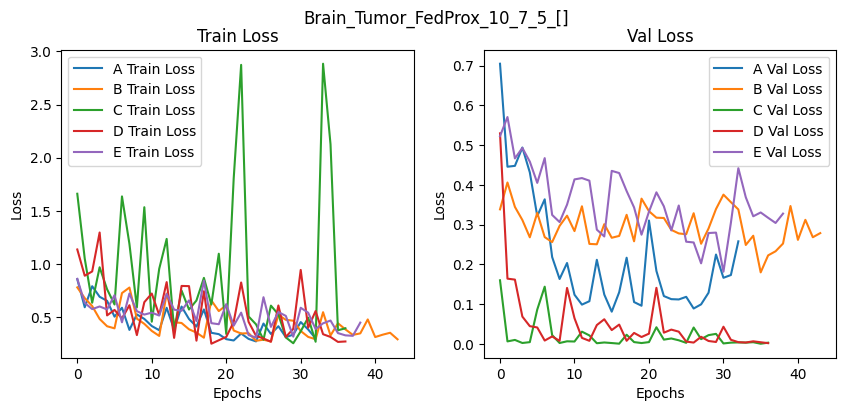

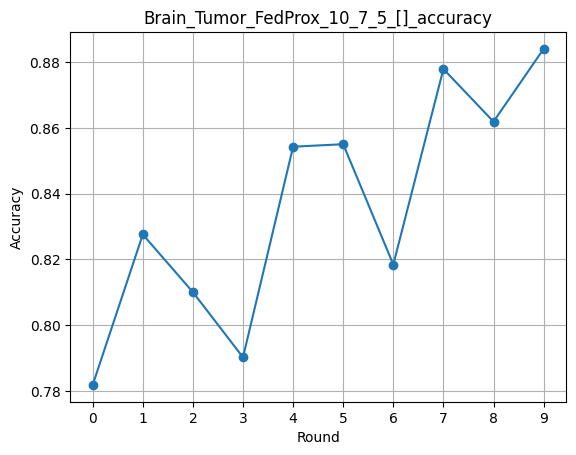

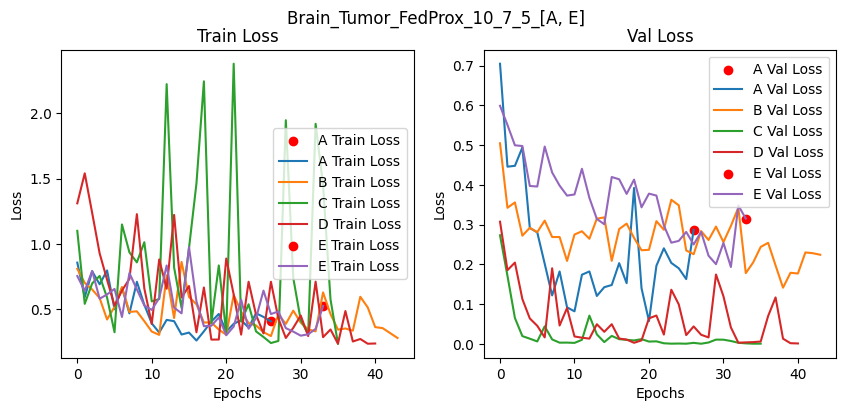

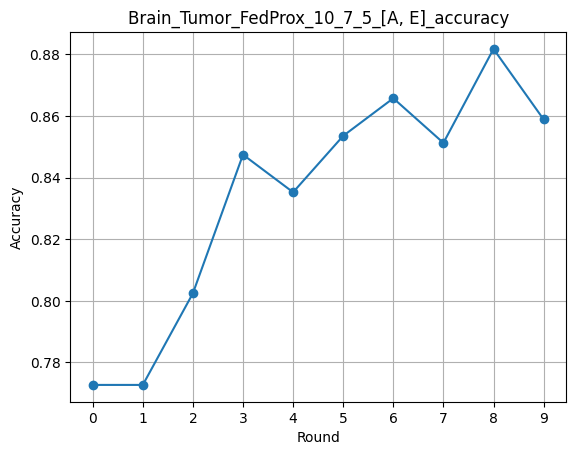

In [3]:
def flatten_json(json_data):
    flattened_data = []
    for device, rounds in json_data.items():
        last_round_losses = None
        for round_num, epochs in rounds.items():
            if epochs == "out_of_battery":
                flattened_data.append({
                    'device': device,
                    'round': round_num,
                    'epoch': 'out_of_battery',
                    'train_loss': None,
                    'val_loss': None
                })
            else:
                for epoch_num, loss_values in epochs.items():
                    entry = {
                        'device': device,
                        'round': round_num,
                        'epoch': epoch_num,
                        'train_loss': float(loss_values[0]),
                        'val_loss': float(loss_values[1])
                    }
                    flattened_data.append(entry)
    return flattened_data

for dir in os.listdir(RESULT_PATH):
  for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
    if data_file.endswith('.json'):
      if data_file.endswith('accuracy.json'):
          path = os.path.join(RESULT_PATH,dir,data_file)
          with open(path, 'r') as file:
              data = json.load(file)
          rounds = list(data.keys())
          accuracies = list(data.values())
          pattern = re.compile(r'\[.*?\]')
          title = re.sub(pattern, lambda match: match.group(0).replace('_', ''), data_file)
          plt.plot(rounds, accuracies, marker='o')
          plt.title(f"{title[:-len('.json')]}")
          plt.xlabel('Round')
          plt.ylabel('Accuracy')
          plt.grid(True)
          plt.show()
      else:
          path = os.path.join(RESULT_PATH,dir,data_file)
          with open(path, 'r') as file:
              data = json.load(file)
          
          pattern = re.compile(r'\[.*?\]')
          title = re.sub(pattern, lambda match: match.group(0).replace('_', ''), data_file)
        
        

          # Flatten the JSON data
          flattened_data = flatten_json(data)
          # Separate train and val losses for each device
          train_losses = {device: {'values': [], 'out_of_battery': False} for device in data.keys()}
          val_losses = {device: {'values': [], 'out_of_battery': False} for device in data.keys()}

          for entry in flattened_data:
              if entry['epoch'] == 'out_of_battery':
                  train_losses[entry['device']]['out_of_battery'] = True
                  val_losses[entry['device']]['out_of_battery'] = True
              else:
                  train_losses[entry['device']]['values'].append(entry['train_loss'])
                  val_losses[entry['device']]['values'].append(entry['val_loss'])

          # Plotting train and validation losses side by side
          fig, axs = plt.subplots(1, 2, figsize=(10, 4))

          # Plotting train losses
          for device, losses in train_losses.items():
              if losses['out_of_battery']:
                  axs[0].scatter(len(losses['values']) - 1, losses['values'][-1], color='red', marker='o',
                                label=f'{device} Train Loss')
              axs[0].plot(losses['values'], label=f'{device} Train Loss')

          axs[0].set_title(f'Train Loss')
          axs[0].set_xlabel('Epochs')
          axs[0].set_ylabel('Loss')
          axs[0].legend()

          # Plotting validation losses
          for device, losses in val_losses.items():
              if losses['out_of_battery']:
                  axs[1].scatter(len(losses['values']) - 1, losses['values'][-1], color='red', marker='o',
                                label=f'{device} Val Loss')
              axs[1].plot(losses['values'], label=f'{device} Val Loss')

          axs[1].set_title(f'Val Loss')
          axs[1].set_xlabel('Epochs')
          axs[1].set_ylabel('Loss')
          axs[1].legend()
          plt.suptitle(title[:-len('.json')])
          plt.show()

In [4]:
from prettytable import PrettyTable
import numpy as np
for dir in sorted(os.listdir(RESULT_PATH)):
    table = PrettyTable()
    table.field_names = ["N. Devices","Agg. Method", "Round", "Epochs","Dev. OFB","Accuracy"]
    
    for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
        if data_file.endswith('accuracy.json'):
           
           info = data_file.split('_')
           path = os.path.join(RESULT_PATH,dir,data_file)
           
           with open(path, 'r') as file:
              data = json.load(file)
           max_val = np.round(np.max(list(data.values())),2)

           if len(info) == 8:
              info = [' '.join(info[:2])] + info[2:]

           row = [info[4],info[1],info[2],info[3],info[5],max_val]

           table.add_row(row)
    table.title = dir
    table.sortby = "Accuracy"
    table.reversesort = True
    print(table)

+-------------------------------------------------------------------+
|                             Alzheimer                             |
+------------+---------------+-------+--------+----------+----------+
| N. Devices |  Agg. Method  | Round | Epochs | Dev. OFB | Accuracy |
+------------+---------------+-------+--------+----------+----------+
|     5      | FedProx0.0001 |   10  |   7    |    []    |   0.96   |
|     5      | FedProx0.0001 |   10  |   7    |    [     |   0.96   |
|     5      |     FedAvg    |   10  |   7    |    []    |   0.95   |
|     5      |     FedAvg    |   10  |   7    |    [     |   0.95   |
|     3      |  FedProx0.001 |   10  |   5    |    []    |   0.95   |
|     3      | FedProx0.0001 |   10  |   5    |    []    |   0.95   |
|     3      |     FedAvg    |   10  |   5    |    []    |   0.95   |
|     3      |     FedAvg    |   10  |   5    |    [     |   0.94   |
|     20     |  FedProx0.001 |   20  |   10   |    []    |   0.94   |
|     10     |     F